In [15]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Generate fake

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def normalize(x):
    # Normalize according to: Normalization
    x_min = x.min()
    x_max = x.max()
    
    if (x_max -x_min) == 0:
         x = np.zeros_like(x)
    else:
        x = (x-x_min)/(x_max -x_min)
    return x


In [18]:


def normalize(x):
    # Normalize according to: Standardizatio
    # https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/
    x_mean = x.mean()
    x_std = x.std()
    
    if x_std == 0:
        x = np.zeros_like(x)
    else:
        x = (x-x_mean)/(x_std)
    return x

def plot_example(select_samples, fail=1):
    sample_from = random.randint(min(data_info[f"index_{fail}"]), max(data_info[f"index_{fail}"])-select_samples)
    fig, ax = plt.subplots(select_samples,1,figsize=(12,12))
    for i,j in enumerate(range(sample_from, sample_from+select_samples)):

        ax[i].plot(data[j][0].T)
    plt.show()


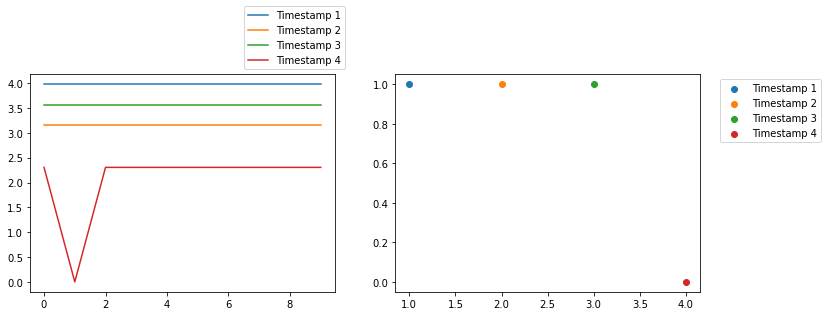

In [19]:
time_steps = 5
n_cells = 10 # Amount of cells in pack
x = np.zeros([time_steps,n_cells])


fig, ax = plt.subplots(1,2,figsize=(12,4))

failed_cell = 1 # Which cell is the failing cell
is_fail = True# Does the pack include a failed cell
volt_stochastic = 0.5
for i in range(1,time_steps):
    sigma = 0.0 # How much is the fluctuation
    median = random.uniform(2, 4)
    volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
    y = 1
    if is_fail:
        r = random.random()
        if r < volt_stochastic:
            stochstic_amplifier = random.randint(1,10)
            
            y = (1-i/stochstic_amplifier)
            #print(y)
            volt[failed_cell]*=y
    ax[1].scatter(i,y,label=f"Timestamp {i}")
    ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax[1] = plt.gca()
    #ax[1].set_ylim(ax[1].get_ylim()[::-1])
    x[i,:] = volt
            
    ax[0].plot(volt,label=f"Timestamp {i}")
    ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='lower right')
#plt.ylim(0,16)
#plt.legend()



#plt.scatter(x_arr, y_arr)
#ax = plt.gca()
#ax.set_ylim(ax.get_ylim()[::-1])

In [20]:
def create_sequence(time_steps=2, n_cells=4, failed_cell=1, is_fail=True, sigma=0.0, volt_stochastic = 0.9, normalize_x=False):
    x = np.zeros([time_steps,n_cells])
    for i in range(0,time_steps):
        median = random.uniform(2, 4)
        volt = np.random.normal(loc=median, scale=sigma, size=n_cells)
        if is_fail:
            r = random.random()
            if r < volt_stochastic:
                stochstic_amplifier = random.randint(1,10) # 100, 1000

                y = (1-(i+1)/stochstic_amplifier)
                #print(y)
                volt[failed_cell]*=y
        x[i,:] = volt
    if normalize_x:
        x_norm = np.zeros_like(x)
        for i in range(len(x)):
            x_norm[i,:] = normalize(x[i,:])
        #x = normalize(x)
        x = x_norm
    if is_fail:
        label = 1
    else:
        label = 0
    return x, label
    

In [21]:
time_steps=20 
n_cells=108
failed_cell=1 
sigma=0
volt_stochastic = 0.5
normalize_x=True

def create_data(n_healthy=2, n_fails=2,time_steps=time_steps, random_cell_fail=False, failed_cell=3,sigma=sigma, volt_stochastic=volt_stochastic, n_cells=n_cells):
    data = []
    
    data_info ={"index_1":[],
           "index_0": []} 
    for i in range(n_healthy+n_fails):
        if i >= n_healthy:
            fail=True
        else:
            fail=False
        if random_cell_fail:
            failed_cell = random.randint(0,n_cells-1)
        #else:
            #continue

        x,y = create_sequence(time_steps=time_steps, n_cells=n_cells, failed_cell=failed_cell, is_fail=fail, sigma=sigma, volt_stochastic=volt_stochastic, normalize_x=normalize_x)
        data.append((torch.FloatTensor(x),y))
        
        #Finn data_info
        if y == 1:
            data_info["index_1"].append(i)
            
        if y == 0:
            data_info["index_0"].append(i)
            
    return (data, data_info)
    

data, data_info = create_data(n_healthy=1000, n_fails=1000,random_cell_fail=False, failed_cell=3)

## plot n random samples from failed

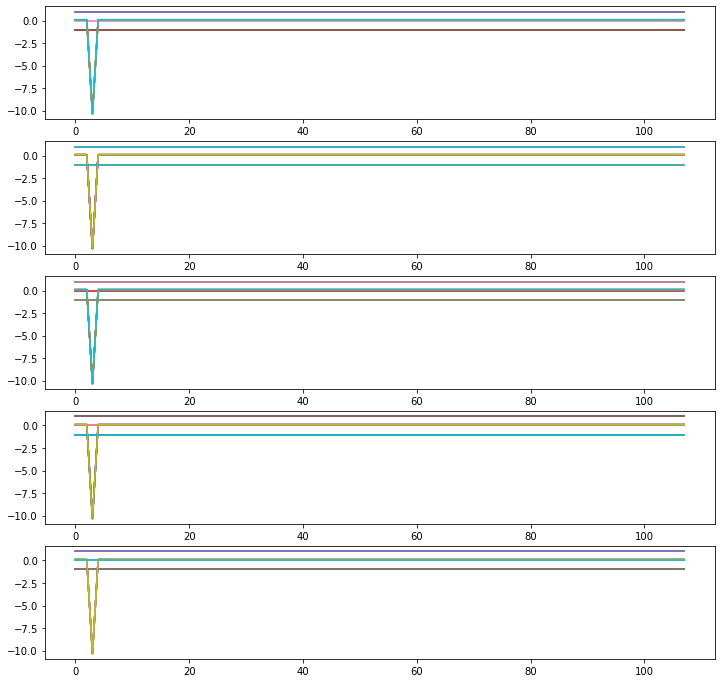

In [22]:
select_samples = 5
sample_from = random.randint(min(data_info["index_1"]), max(data_info["index_1"])-select_samples)
fig, ax = plt.subplots(select_samples,1,figsize=(12,12))
for i,j in enumerate(range(sample_from, sample_from+select_samples)):

    ax[i].plot(data[j][0].T)
plt.show()

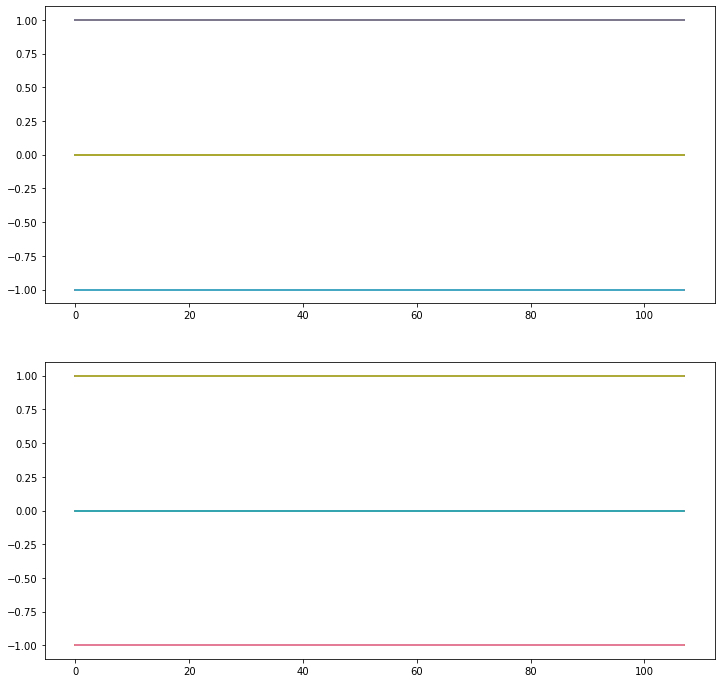

In [23]:
plot_example(select_samples=2, fail=0)

## Create dataset

In [99]:
time_steps=10
n_cells=108
failed_cell=50 
sigma=0.0
volt_stochastic = 0.9
normalize_x=False
random_cell_fail=False
n_healthy = 1000
n_fails = 100

data, data_info = create_data(n_healthy=n_healthy, n_fails=n_fails, time_steps=time_steps, random_cell_fail=random_cell_fail, failed_cell=failed_cell,sigma=sigma, volt_stochastic=volt_stochastic, n_cells=n_cells)

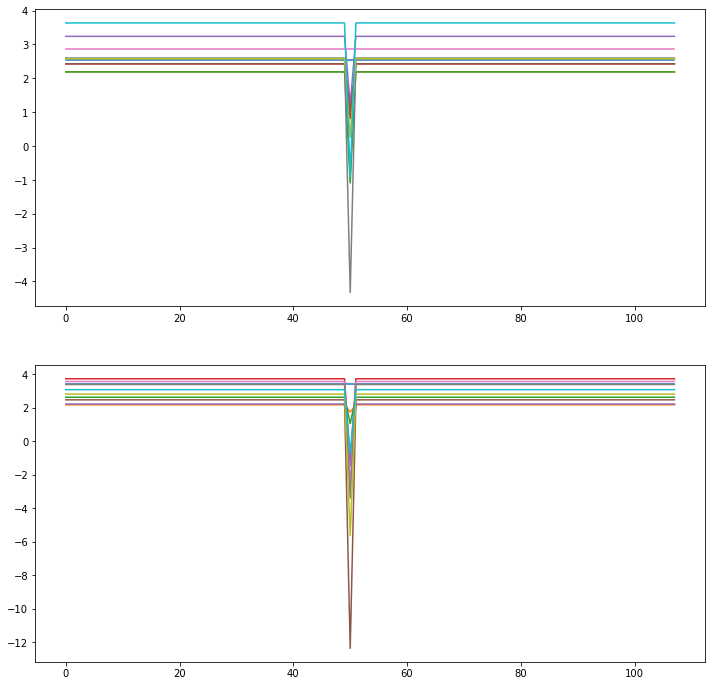

In [100]:
plot_example(select_samples=2, fail=1)

In [101]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size
train_set, test_set = torch.utils.data.random_split(data,[train_size, test_size])
batch_size = 10
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True,drop_last=True)

In [102]:
for (X_train, y_train) in train_loader:
    break

In [103]:
X_train.shape

torch.Size([10, 10, 108])

In [104]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import seaborn as sns


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline

In [123]:
test_loader_all = DataLoader(dataset=test_set, batch_size=len(test_set), shuffle=True,drop_last=True)
train_loader_all = DataLoader(dataset=train_set, batch_size=len(train_set), shuffle=True,drop_last=True)
for x_test, y_test in test_loader_all:
    break
for x_train, y_train in train_loader_all:
    break
x_test = x_test.numpy().reshape(220,-1)
y_test = y_test.numpy().reshape(220,-1)
x_train = x_train.numpy().reshape(880,-1)
y_train = y_train.numpy().reshape(880,-1)
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(220, 1080)
(220, 1)
(880, 1080)
(880, 1)


(220, 1080)

In [107]:
x_test = x_test.reshape(220,10*108)
y_test = y_test.reshape(1,-1)
x_test = np.array(x_train.tolist())
y_test = np.array(y_train.tolist())

x_train = X_test.reshape(880,-1)
y_train = y_test.reshape(880,-1)
x_train = np.array(x_train.tolist())
y_train = np.array(y_train.tolist())

print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(880, 10, 108)
(880,)
(880, 81)
(880, 1)


In [124]:
class Autoencoder(keras.Model):
    def __init__(self, bottle_neck):
        super(Autoencoder, self).__init__()
        self.bottle_neck = bottle_neck
        
        glorot= tf.keras.initializers.GlorotUniform()
        # Encoder
        self.encoder = Sequential([Input(1080),
                                   Dense(50, kernel_initializer=glorot, activation="relu"), # Layer 2
                                  Dense(self.bottle_neck, kernel_initializer=glorot, activation="relu")]) # Layer 3
        # Decoder
        self.decoder = Sequential([Dense(1080, kernel_initializer=glorot, activation="relu")])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [125]:
# Initialize encoders
autoencoder1 = Autoencoder(2)
autoencoder2 = Autoencoder(4)

# Compile encoders
adam = Adam(learning_rate=0.001)
autoencoder1.compile(optimizer=adam, loss="mse")
autoencoder2.compile(optimizer=adam, loss="mse")

In [126]:
# Fit encoders
epochs = 800
batch_size=10
autoencoder1.fit(x_train, x_train, epochs=epochs,batch_size=batch_size, shuffle=True,validation_data=(x_test, y_test))
#autoencoder2.fit(x_train, x_train, epochs=epochs,batch_size=batch_size, shuffle=True,validation_data=(x_test, y_test))

Epoch 1/800
88/88 [==============================] - 0s 2ms/step - loss: 4.7577 - val_loss: 4.7989
Epoch 2/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3907 - val_loss: 4.8719
Epoch 3/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3900 - val_loss: 4.8813
Epoch 4/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3903 - val_loss: 4.8921
Epoch 5/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3895 - val_loss: 4.8585
Epoch 6/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3757 - val_loss: 4.8427
Epoch 7/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3720 - val_loss: 4.8741
Epoch 8/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3706 - val_loss: 4.8985
Epoch 9/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3696 - val_loss: 4.8765
Epoch 10/800
88/88 [==============================] - 0s 1ms/step - loss: 4.3673 - val_loss: 4.8877
Epoch 11/

88/88 [==============================] - 0s 1ms/step - loss: 4.0746 - val_loss: 5.1979
Epoch 84/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0673 - val_loss: 5.1618
Epoch 85/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0660 - val_loss: 5.1883
Epoch 86/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0651 - val_loss: 5.1788
Epoch 87/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0635 - val_loss: 5.0984
Epoch 88/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0538 - val_loss: 5.1175
Epoch 89/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0504 - val_loss: 5.0131
Epoch 90/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0503 - val_loss: 5.1595
Epoch 91/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0494 - val_loss: 5.1463
Epoch 92/800
88/88 [==============================] - 0s 1ms/step - loss: 4.0502 - val_loss: 5.1763
Epoch 93/800


88/88 [==============================] - 0s 1ms/step - loss: 3.2674 - val_loss: 5.9968
Epoch 165/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2671 - val_loss: 5.9444
Epoch 166/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2667 - val_loss: 6.0187
Epoch 167/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2657 - val_loss: 5.9420
Epoch 168/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2471 - val_loss: 5.9844
Epoch 169/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2167 - val_loss: 5.9633
Epoch 170/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2084 - val_loss: 5.9854
Epoch 171/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2082 - val_loss: 6.1266
Epoch 172/800
88/88 [==============================] - 0s 1ms/step - loss: 3.2008 - val_loss: 6.0371
Epoch 173/800
88/88 [==============================] - 0s 1ms/step - loss: 3.1996 - val_loss: 5.8990
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.7685 - val_loss: 6.3580
Epoch 246/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7687 - val_loss: 6.3881
Epoch 247/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7687 - val_loss: 6.5174
Epoch 248/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7687 - val_loss: 6.4008
Epoch 249/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7689 - val_loss: 6.5359
Epoch 250/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7690 - val_loss: 6.3838
Epoch 251/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7694 - val_loss: 6.3401
Epoch 252/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7684 - val_loss: 6.4307
Epoch 253/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7686 - val_loss: 6.3797
Epoch 254/800
88/88 [==============================] - 0s 1ms/step - loss: 2.7689 - val_loss: 6.3156
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.5327 - val_loss: 6.5779
Epoch 327/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5332 - val_loss: 6.5700
Epoch 328/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5326 - val_loss: 6.6120
Epoch 329/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5326 - val_loss: 6.7291
Epoch 330/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5328 - val_loss: 6.5844
Epoch 331/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5333 - val_loss: 6.6739
Epoch 332/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5339 - val_loss: 6.6052
Epoch 333/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5327 - val_loss: 6.6313
Epoch 334/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5326 - val_loss: 6.6435
Epoch 335/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5328 - val_loss: 6.6421
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.5328 - val_loss: 6.6102
Epoch 408/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5325 - val_loss: 6.6978
Epoch 409/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5328 - val_loss: 6.6295
Epoch 410/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5324 - val_loss: 6.6384
Epoch 411/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5325 - val_loss: 6.5925
Epoch 412/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5325 - val_loss: 6.6606
Epoch 413/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5323 - val_loss: 6.5895
Epoch 414/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5323 - val_loss: 6.6761
Epoch 415/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5324 - val_loss: 6.6177
Epoch 416/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5320 - val_loss: 6.5933
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6533
Epoch 489/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.5938
Epoch 490/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6796
Epoch 491/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5326 - val_loss: 6.5971
Epoch 492/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6198
Epoch 493/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5324 - val_loss: 6.6339
Epoch 494/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5325 - val_loss: 6.6227
Epoch 495/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5325 - val_loss: 6.6892
Epoch 496/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6004
Epoch 497/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5320 - val_loss: 6.6143
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6325
Epoch 570/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5320 - val_loss: 6.6150
Epoch 571/800
88/88 [==============================] - 0s 2ms/step - loss: 2.5319 - val_loss: 6.6081
Epoch 572/800
88/88 [==============================] - 0s 2ms/step - loss: 2.5321 - val_loss: 6.6407
Epoch 573/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5323 - val_loss: 6.6483
Epoch 574/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5321 - val_loss: 6.6037
Epoch 575/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.5900
Epoch 576/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6621
Epoch 577/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5325 - val_loss: 6.6559
Epoch 578/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5319 - val_loss: 6.5895
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.5319 - val_loss: 6.6305
Epoch 651/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5317 - val_loss: 6.6333
Epoch 652/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5317 - val_loss: 6.6571
Epoch 653/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5322 - val_loss: 6.6205
Epoch 654/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5319 - val_loss: 6.6560
Epoch 655/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5320 - val_loss: 6.6616
Epoch 656/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5319 - val_loss: 6.6438
Epoch 657/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5317 - val_loss: 6.6609
Epoch 658/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5320 - val_loss: 6.5801
Epoch 659/800
88/88 [==============================] - 0s 2ms/step - loss: 2.5323 - val_loss: 6.6435
Epoc

88/88 [==============================] - 0s 1ms/step - loss: 2.5312 - val_loss: 6.6439
Epoch 732/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5319 - val_loss: 6.6210
Epoch 733/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5318 - val_loss: 6.5415
Epoch 734/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5317 - val_loss: 6.5821
Epoch 735/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5318 - val_loss: 6.5969
Epoch 736/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5326 - val_loss: 6.6095
Epoch 737/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5318 - val_loss: 6.6089
Epoch 738/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5317 - val_loss: 6.6696
Epoch 739/800
88/88 [==============================] - 0s 2ms/step - loss: 2.5319 - val_loss: 6.6531
Epoch 740/800
88/88 [==============================] - 0s 1ms/step - loss: 2.5316 - val_loss: 6.6195
Epoc

In [142]:
#List of index with number
index_list = [list(np.where(y_test==i))[0][0] for i in range(0,1)]

encoded_imgs = autoencoder1.encoder(x_test[index_list]).numpy()
decoded_imgs = autoencoder1.decoder(encoded_imgs).numpy().reshape([-1,1080])



In [145]:
encoded_imgs = autoencoder2.encoder(x_test[index_list]).numpy()
decoded_imgs = autoencoder2.decoder(encoded_imgs).numpy().reshape([-1,1080])

In [146]:
encode1 =autoencoder1.encoder(x_train)

In [147]:
n11 = np.array(encode1[:,0])
n12 = np.array(encode1[:,1])

In [158]:
sns.scatterplot(x=n11,y=n12,hue=y_train,palette="viridis")
#sns.scatterplot(x=n11,y=n12)

ValueError: Data must be 1-dimensional

In [159]:
y_train

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [160]:
Y_train = []
for i in y_train:
    Y_train.extend(i)

In [162]:
np.array(Y_train)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,